In [139]:
import numpy as np
from obspy.core.trace import Trace
import cwt
import cwt
from matplotlib import pyplot as plt

Add notes on data 

In [159]:
#load data with shape (nchannels, nSamples)
window_one = np.load("./TestData/stanford_numpy/2016-09-02_23:59:54training_prep.npy")
window_two =np.load("./TestData/stanford_numpy/2016-09-03_00:01:54training_prep.npy")

print("data shape: ", window_one.shape)

data = np.concatenate([window_one, window_two], axis=1, dtype=np.float64)
print(data.shape)

data shape:  (286, 15000)
(286, 30000)


### Parameter for CWT that will be used later 

window_size: the length of the cwt window in seconds

n_channels: the number of channels in the data 

n_samples: the total samples in the data

n_features: number of features per sample after performing cwt 30 will be on the time axis 30 will be on the spacial axis

samples_per_second: samples taken per second at each channel

samples_within_average: the amount of cwt features that will be average per set in the final output

n_sub_samples: n_samples/samples_within_average amount of samples that will be in the final output

delta: 1/samples_per_second or the sample period 

freq_min: min frequency allowed through bandpass filter 

freq_max: max frequency allowed through bandpass filter

freq_min_space: min frequency used for the spatial scales of cwt 

freq_max_space: max frequency used for spatial scales of cwt

time_scales: scales for time cwt 

spatial_scales: scales for spatial cwt



In [160]:
window_size = 300
n_channels = data.shape[0]
n_samples = data.shape[1]
n_features = 60
samples_per_second = 50
samples_within_average = 25
n_sub_samples = int(n_samples / samples_within_average)
delta = 1.0 / float(samples_per_second)
freq_min = 0.2
freq_max = 24.0
freq_min_space= 0.04
freq_max_space= 2

time_log = np.logspace(np.log10(freq_min), np.log10(freq_max), 30)
space_log = np.logspace(np.log10(freq_min_space), np.log10(freq_max_space), 30)

time_scales = cwt.scales_from_fourier(time_log, wf="morlet", w0=8)
spatial_scales = cwt.scales_from_fourier(space_log, wf="morlet", w0=8)

## This transforms one window of data 

In [161]:
def transform_window(data):
    n_samples=data.shape[1]
    
    #take time derivative 
    data_derivative = data[:, 1:] - data[:, :-1]

    # perform bandpass filter to remove high and low frequencies
    for channel in range(n_channels):
        trace = Trace(data=data_derivative[channel, :], header={'delta':1.0/float(samples_per_second),'sampling_rate':samples_per_second})
        trace = trace.filter("bandpass", freqmin= freq_min, freqmax= freq_max, corners=4, zerophase=True)
        data_derivative[channel, :] = trace.data
        

    #remove lazer drift/ remove median
    data_derivative = data_derivative - np.median(data_derivative, axis=0)
    print("data before Transform ", data_derivative.shape)


    transformed_data = np.empty((n_channels, n_samples-1, 60), dtype=np.float64)

    for index, sample in enumerate(data_derivative):
        transformed_data[index, : , :30] = np.abs(cwt.cwt(sample, delta, time_scales, wf="morlet", w0=8).T) #

    for index, channel in enumerate(data_derivative.T):
        transformed_data[:, index, 30:] = np.abs(cwt.cwt(channel, delta, spatial_scales, wf='morlet', w0=8).T)
    print(transformed_data.shape)

    #average samples over 0.5 second intervals 

    #start is at 250 since stanford windows start at 54.9 so add 5 seconds to start at the top of 
    reshaped_data = np.reshape(transformed_data[:, 250: 7750, :], (n_channels, 300, samples_within_average, 60))

    averaged_data = np.mean(reshaped_data, axis=2)
    return averaged_data




In [163]:

#this is the same as therer 
result = np.empty((n_channels, 600, 60), dtype=np.float64)
result[:,:300,:] = transform_window(window_one)
result[:,300:,:] = transform_window(window_two)
#result[:,300:,:] = transform_window(window_one[:, ])
#result[:, 300:, :] = transform_window(data[:, 4000: 11501])
print(result)

data before Transform  (286, 14999)
(286, 14999, 60)
data before Transform  (286, 14999)
(286, 14999, 60)
[[[0.00254671 0.00229501 0.00714116 ... 0.09567858 0.08728379 0.10200515]
  [0.0057435  0.006511   0.0087768  ... 0.09526412 0.10103162 0.12592058]
  [0.00256726 0.00716218 0.0072843  ... 0.06746067 0.0850241  0.1046792 ]
  ...
  [0.00398035 0.00400577 0.00404529 ... 0.05293148 0.0471413  0.05499815]
  [0.00551461 0.00300484 0.00614829 ... 0.05737527 0.06269967 0.07372117]
  [0.00518333 0.00429023 0.00556903 ... 0.05360005 0.05507576 0.06438864]]

 [[0.01104347 0.00828881 0.00786519 ... 0.09618831 0.08763421 0.10209968]
  [0.0106727  0.00546575 0.00390175 ... 0.09584122 0.10140717 0.12601354]
  [0.00409319 0.00580849 0.00220261 ... 0.06778747 0.08525891 0.1047605 ]
  ...
  [0.00515518 0.00621753 0.00560463 ... 0.05309538 0.04729702 0.05505742]
  [0.01367793 0.0084578  0.00562232 ... 0.05765233 0.06289571 0.07377364]
  [0.01021019 0.00776917 0.00650058 ... 0.05390424 0.05525664 0.06

In [164]:

#Do normilization 
trainingData = result
print(trainingData.shape)
trainingData = np.reshape(trainingData, (n_channels * trainingData.shape[1], -1))
print(trainingData.shape)

#does the same thing as the papers sklearn 
trainingData = (trainingData - np.mean(trainingData, axis=0, keepdims=True)) / np.std(trainingData, axis=0, keepdims=True)
normed_data = trainingData.reshape(n_channels, 600, 60)
print(normed_data.shape)

(286, 600, 60)
(171600, 60)
(286, 600, 60)


In [165]:
#calculate the scales for graphs 

minFrq = 0.5
maxFrq = 24
minSpaceFrq = 0.002
maxSpaceFrq = 0.12
nf = 30
# logspace from paper implemenation 
ftime = np.logspace(np.log10(minFrq), np.log10(maxFrq), nf)
fspace = np.logspace(np.log10(minSpaceFrq), np.log10(maxSpaceFrq), nf)

wf = "morlet"
w0 = 8

#scales from paper implementation 
time_scales = cwt.scales_from_fourier(ftime, wf , w0)
scalesSpace = cwt.scales_from_fourier(fspace, wf, w0)


#are these pseudo frequencies ? 
time_fourier = cwt.fourier_from_scales(time_scales, wf, w0)
space_fourier = cwt.fourier_from_scales(scalesSpace, wf, w0)

/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_32876/939395029.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


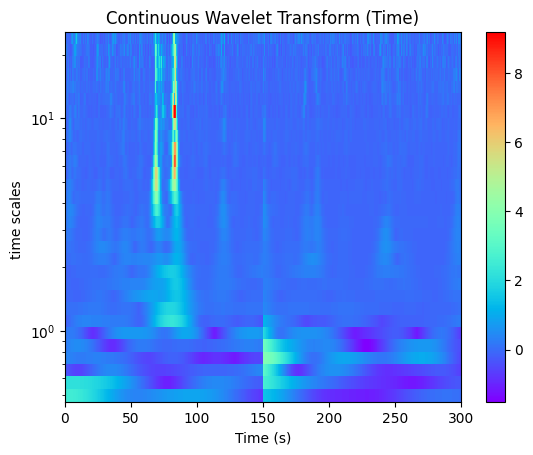

In [166]:

time_data = normed_data[127][:,:30]

time = np.linspace(0, 300, 600)
fig, axs = plt.subplots()


pcm = axs.pcolormesh(time, time_fourier[::-1], time_data.T, shading="nearest", cmap="rainbow")
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_ylabel("time scales ")
axs.set_title("Continuous Wavelet Transform (Time)")
fig.colorbar(pcm, ax=axs)
fig.show()


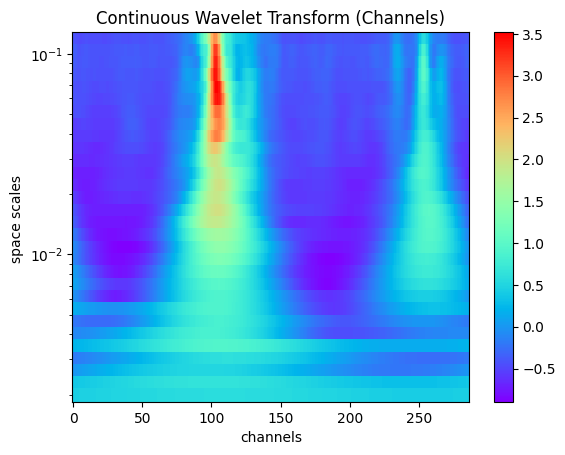

In [167]:
channels_data = normed_data[:,100,30:]

channels = np.linspace(0, 286, 286)
fig, axs = plt.subplots()
pcm = axs.pcolormesh(channels, space_fourier[::-1], channels_data.T,  shading="nearest", cmap="rainbow")
axs.set_yscale("log")
axs.set_xlabel("channels")
axs.set_ylabel("space scales ")
axs.set_title("Continuous Wavelet Transform (Channels)")
fig.colorbar(pcm, ax=axs)